In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchvision
import numpy as np
from numpy.linalg import inv
from numpy.linalg import solve
import scipy.spatial.distance as dist
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [ ]:
def Gauss(x, c_l, sigma):
  phi_l_x = np.exp((-0.5 * (np.linalg.norm(x - c_l))**2)/(sigma**2))
  return phi_l_x

def GaussBasis(X, C, sigma):
  phi = []
  for i in tqdm(range(len(C))):
    c_l = C[i]
    temp = []
    for x in X:
      temp.append(Gauss(x, c_l, sigma))
    phi.append(temp)
  return phi

In [ ]:
def CalculateDist2(X, Y):
  # calculate squared distance using cdist
  sq_dist = dist.cdist(X.T, Y.T, metric='sqeuclidean')
  med_dist = np.sqrt(np.median(sq_dist))
  return sq_dist, med_dist

In [ ]:
def accu(L1, L2):
  sum = 0
  for i in range(len(L1)):
    if L1[i]==L2[i]:
      sum += 1

  return (sum/len(L1))*100

In [ ]:
def PEPriorEst(X_p, X_m, sigma_list, lambda_list, kfolds):

  xp = X_p[:,:-1]
  yp_label = X_p[:,-1]

  xm = X_m[:,:-1]
  ym_label = X_m[:,-1]

  n1 = np.shape(xp)[0] #no. of positive labeled samples
  n2 = np.shape(xm)[0] #no. of unlabeled samples
 
  #split the data into training and test folds
  cv_split_xp = np.floor(np.arange(0, n1, 1) * kfolds / n1) + 1 
  cv_split_xm = np.floor(np.arange(0, n2, 1) * kfolds / n2) + 1

  ind = []

  for k in range(1, kfolds+1):
    ind.append([np.where(cv_split_xp != k)[0][0], np.where(cv_split_xp != k)[0][-1], np.where(cv_split_xp == k)[0][0], np.where(cv_split_xp == k)[0][-1], np.where(cv_split_xm != k)[0][0], np.where(cv_split_xm != k)[0][-1], np.where(cv_split_xm == k)[0][0], np.where(cv_split_xm == k)[0][-1] ])

  del cv_split_xp
  del cv_split_xm

  fold_data = []

  theta_lst = [ 0.2, 0.4, 0.6, 0.8]
  hyperparam_dict = {}
  
  x_test =xm  
  y_test = ym_label

  for theta in theta_lst:
    print('Theta :', theta)
    cv_scores = np.zeros((len(sigma_list), len(lambda_list)))

    for k in range(0, kfolds):

      print("----------------------------------")
      print('K = ', k+1)
      print("----------------------------------")

      #get the training and test datasets
      idx_xp_tr = [ind[k][0], ind[k][1]]
      idx_xp_val = [ind[k][2], ind[k][3]]

      idx_xm_tr = [ind[k][4], ind[k][5]]
      idx_xm_val = [ind[k][6], ind[k][7]]

      xp_tr = xp[idx_xp_tr[0] : idx_xp_tr[-1], :]
      xp_val = xp[idx_xp_val[0] : idx_xp_val[-1], :]

      xm_tr = xm[idx_xm_tr[0] : idx_xm_tr[-1], :]
      xm_val = xm[idx_xm_val[0] : idx_xm_val[-1], :]

      #set the basis functions (numerator without test samples)

      x_ce = xp_tr
      b = np.array(x_ce).shape[0]

      for sigma_idx in tqdm(range(len(sigma_list))):

        sigma = sigma_list[sigma_idx]
        print('sigma = ', sigma)

        #Calculate the Phi matrices
        Phi1_tr = GaussBasis(xp_tr, x_ce, sigma)
        Phi1_val = GaussBasis(xp_val, x_ce, sigma)

        Phi2_tr = GaussBasis(xm_tr, x_ce, sigma)
        Phi2_val = GaussBasis(xm_val, x_ce, sigma)

        for lmbda_idx in range(len(lambda_list)):
          lmbda = lambda_list[lmbda_idx]
          print('lambda = ', lmbda)

          #Calculating the alphas on training set (xp_tr)
          alpha_lst = []
          for l in range(b):
            #print('beta__1',theta * ( np.mean(Phi1_tr[l]) ) - ( np.mean(Phi2_tr[l]) ))
            #print('len phi',[len(Phi2_tr[l] ), ( np.mean(Phi2_tr[l]) )])
            beta__l =( theta * ( np.mean(Phi1_tr[l]) ) - ( np.mean(Phi2_tr[l]) ))
            alpha__l =  ( max(0 , beta__l) )/lmbda
            alpha_lst.append(alpha__l)
            #print('alpha_lst: ', alpha_lst)

          f = []
          for l in range(b):
            beta__l =  (theta * ( np.mean(Phi1_val[l]) ) - ( np.mean(Phi2_val[l]) ))
            f.append( ((lmbda*((alpha_lst[l])**2)) / 2) - (alpha_lst[l]*beta__l))
          score = np.sum(f) 
          
          cv_scores[sigma_idx][lmbda_idx] += score
          #print(f'cv_score, score ({sigma, lmbda}) :, {cv_scores[sigma_idx][lmbda_idx]}, {score }')
        #end lamda_lst
        
        del Phi1_tr
        del Phi2_tr
        del Phi1_val
        del Phi2_val
        del alpha_lst
      #end sigma_lst

    #end kfold 

    idxp = np.where(cv_scores == np.min(cv_scores))[0][0]
    idxm = np.where(cv_scores == np.min(cv_scores))[1][0]

    del cv_scores

    sigma_chosen = sigma_list[idxp]
    lambda_chosen = lambda_list[idxm]

    #selecting hyperparameter for theta
    hyperparam_dict[theta] = (sigma_chosen, lambda_chosen)
 
  #end theta_lst
  print('Hyperparameters choosen via cross-validation for each theta :\n', hyperparam_dict) 

  #setup the basis functions and calculate Phi
  x_ce =  xp
  b = x_ce.shape[0]


  pen_L1_lst = []
  for theta, param in hyperparam_dict.items():
    sigma = param[0]
    lamda = param[1]
    Phi1 = GaussBasis(xp, x_ce, sigma)
    Phi2 = GaussBasis(xm, x_ce, sigma)
    fun_val = 0
    for l in range(b):
      beta__l = (theta * ( np.mean(Phi1[l]) ) - ( np.mean(Phi2[l]) ))
      #print('beta',beta__l)
      fun_val = fun_val + max(0,beta__l) * beta__l
      #print('fun_val ',fun_val)  
    #print('fun_val/lamda ',fun_val/lamda )   
    pen_L1 = ( fun_val/lamda ) - theta + 1
    pen_L1_lst.append(pen_L1)

    del Phi1
    del Phi2
    del sigma
    del lamda
    del fun_val

 # print(pen_L1_lst)
  pen_L1_min_idx = np.argmin(pen_L1_lst)
  prior = theta_lst[pen_L1_min_idx]

  sigma = hyperparam_dict[prior][0]
  lamda = hyperparam_dict[prior][1]

  Phi1 = GaussBasis(xp, x_ce, sigma)
  Phi2 = GaussBasis(xm, x_ce, sigma)

  #prior = max(prior, n1/(n1+n2))
  prior = min(prior, 1)

  #estimating r(x)
  alpha_lst = []

  for l in range(b):
    beta_l = (prior * (np.mean(Phi1[l]) ) - (np.mean(Phi2[l])))
    #print('beta ', beta_l)
    alpha_l =  ( max(0 , beta_l) )/lamda
    #print('aplha ', alpha_l)
    #print('phi2 =', np.mean(Phi2[l]), 'phi1 =', np.mean(Phi1[l]),'beta=', beta_l,'alpha=', alpha_l )
    alpha_lst.append(alpha_l)
  #print('alpha_lst: ', alpha_lst)
  del Phi1
  del Phi2
  
  prediction_set = []
  #print('b: ', b)
  j = 0
  for x in x_test:
    j +=1
    phi_l_x_i =  [Gauss(x, x_l, sigma) for x_l in x_ce]
    #print('len phi_l_xi: ', len(phi_l_x_i))
    #print('len(aplha_lst ', len(alpha_lst))
    r_xi_hat = np.dot(np.array(alpha_lst), np.array(phi_l_x_i)) 
    #print('r_xi_hat:',r_xi_hat )

    #Prediction part
    if (prior*r_xi_hat) >= 0.5 :
      y_pred = 1
    else:
      y_pred = -1
    prediction_set.append(y_pred)
  
  del phi_l_x_i
  del r_xi_hat

  print('Prior - ', prior, '|| Accu -', accu(prediction_set, y_test), '|| Sigma -', sigma, '|| Lambda -', lamda) 
  fold_data.append([prior, accu(prediction_set, y_test), prediction_set, y_test])

  del prediction_set

  return fold_data

In [ ]:
train_data = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
X_train_npa = [x.numpy() for x,_ in train_data]
y_train_npa = [y for _,y in train_data]



"\ntest_data = torchvision.datasets.MNIST('/files/', train=False, download=True,\n                             transform=torchvision.transforms.Compose([\n                               torchvision.transforms.ToTensor(),\n                               torchvision.transforms.Normalize(\n                                 (0.1307,), (0.3081,))\n                             ]))\nX_test_npa = [x.numpy() for x,_ in test_data]\ny_test_npa = [y for _,y in test_data]\n"

In [ ]:
len(X_train_npa), len(y_train_npa)
# len(X_test_npa), len(y_test_npa)

(60000, 60000)

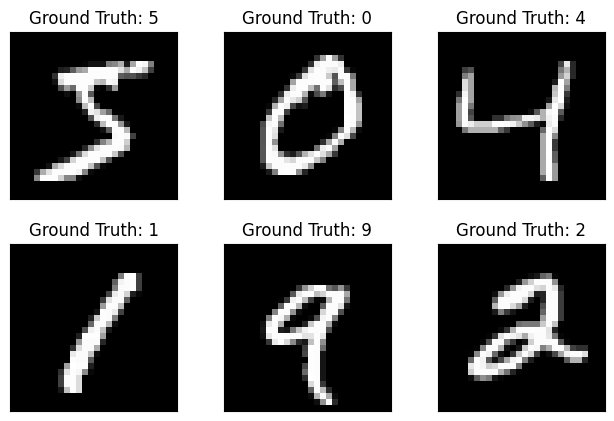

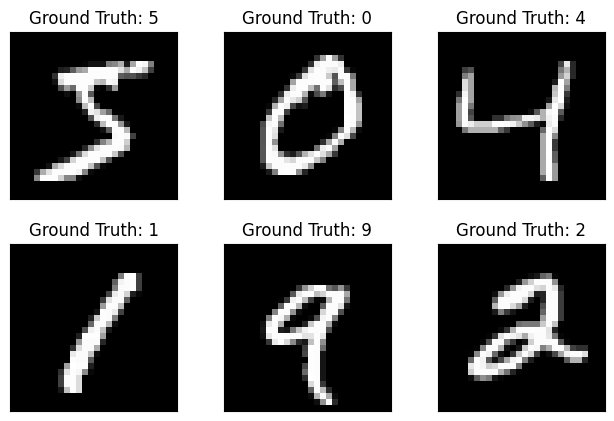

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train_npa[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(y_train_npa[i]))
  plt.xticks([])
  plt.yticks([])
fig

#Experiment 1 - 0.2

In [96]:
xpp = np.array(X_train_npa)[(np.array(y_train_npa) ==1).nonzero()[0]]
xmm = np.array(X_train_npa)[(np.isin(np.array(y_train_npa), [ 2, 3, 4, 5])).nonzero()[0]]
#print(xpp.shape)
#print(xmm.shape)

xp = xpp[1000:1400,0,:,:]
xm = xmm[22000:23300,0,:,:]

xpp = xp
xmm = xm

xp_ = []
for i in xp:
  xp_.append(np.concatenate(i).ravel())

xm_ = []
for i in xm:
  xm_.append(np.concatenate(i).ravel())

xp = np.array(xp_)
xm = np.array(xm_)

x_whole = np.concatenate((xp, xm), axis=0)

pca = PCA(n_components= 4) #creating an object for PCA with components 4
x_whole = pca.fit_transform(x_whole) #fitting and transforming the data
#x_whole = x_whole[ :,:4]

xp = x_whole[:len(xp),:]
xm = x_whole[len(xp):,:]

# concatenate the ones array to xp along the second axis
ones = np.ones((xp.shape[0], 1))
xp = np.concatenate((xp, ones), axis=1)

# concatenate the -1 array to xm along the second axis
ones_neg = - np.ones((xm.shape[0], 1))
xm = np.concatenate((xm , ones_neg), axis=1)

for i in range(300):
  xp_i = xp[i].reshape(1,len(xp[i]))
  xm = np.vstack([xm, xp_i])
  #np.append(xm, xp_i, axis =0)
  del xp_i

#print(xm.shape)  

np.random.shuffle(xp)
np.random.shuffle(xm)


In [97]:
lambda_list= [0.1, 1, 10, 100]
_, med_dist = CalculateDist2(np.concatenate((xpp, xmm))[0], np.concatenate((xpp, xmm))[0])
sigma_list = np.linspace(1/5, 5,4)*med_dist
kfolds = 5

In [98]:
del xpp
del xmm
del xp_
del xm_

In [99]:
print(lambda_list)
print(sigma_list)

[0.1, 1, 10, 100]
[ 1.20476081 10.84284733 20.48093385 30.11902037]


In [ ]:
fold_data = PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds)

Theta : 0.2
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.4
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.6
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.8
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

  0%|          | 0/319 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Hyperparameters choosen via cross-validation for each theta :
 {0.2: (10.842847334672019, 0.1), 0.4: (10.842847334672019, 0.1), 0.6: (10.842847334672019, 0.1), 0.8: (10.842847334672019, 0.1)}


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

Prior -  0.2 || Accu - 81.25 || Sigma - 10.842847334672019 || Lambda - 0.1


# Experiment 2 - 0.4

In [102]:
xpp = np.array(X_train_npa)[(np.array(y_train_npa) ==1).nonzero()[0]]
xmm = np.array(X_train_npa)[(np.isin(np.array(y_train_npa), [ 2, 3, 4, 5])).nonzero()[0]]
#print(xpp.shape)
#print(xmm.shape)

xp = xpp[1000:1800,0,:,:]
xm = xmm[22000:23000,0,:,:]

xpp = xp
xmm = xm

xp_ = []
for i in xp:
  xp_.append(np.concatenate(i).ravel())

xm_ = []
for i in xm:
  xm_.append(np.concatenate(i).ravel())

xp = np.array(xp_)
xm = np.array(xm_)

x_whole = np.concatenate((xp, xm), axis=0)

pca = PCA(n_components= 4) #creating an object for PCA with components 4
x_whole = pca.fit_transform(x_whole) #fitting and transforming the data
#x_whole = x_whole[ :,:4]

xp = x_whole[:len(xp),:]
xm = x_whole[len(xp):,:]

# concatenate the ones array to xp along the second axis
ones = np.ones((xp.shape[0], 1))
xp = np.concatenate((xp, ones), axis=1)

# concatenate the -1 array to xm along the second axis
ones_neg = - np.ones((xm.shape[0], 1))
xm = np.concatenate((xm , ones_neg), axis=1)

for i in range(200):
  xp_i = xp[i].reshape(1,len(xp[i]))
  xm = np.vstack([xm, xp_i])
  #np.append(xm, xp_i, axis =0)
  del xp_i

#print(xm.shape)  

np.random.shuffle(xp)
np.random.shuffle(xm)


In [103]:
lambda_list= [0.1, 1, 10, 100]
_, med_dist = CalculateDist2(np.concatenate((xpp, xmm))[0], np.concatenate((xpp, xmm))[0])
sigma_list = np.linspace(1/5, 5,4)*med_dist
kfolds = 5

In [104]:
del xpp
del xmm
del xp_
del xm_

In [105]:
print(lambda_list)
print(sigma_list)

[0.1, 1, 10, 100]
[ 1.20476081 10.84284733 20.48093385 30.11902037]


In [ ]:
fold_data = PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds)

Theta : 0.2
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.4
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.6
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.8
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

  0%|          | 0/799 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Hyperparameters choosen via cross-validation for each theta :
 {0.2: (1.2047608149635578, 0.1), 0.4: (1.2047608149635578, 0.1), 0.6: (10.842847334672019, 0.1), 0.8: (10.842847334672019, 0.1)}


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Prior -  0.4 || Accu - 84.25 || Sigma - 1.2047608149635578 || Lambda - 0.1


#Experiment 2 - 0.6

In [106]:
xpp = np.array(X_train_npa)[(np.array(y_train_npa) ==1).nonzero()[0]]
xmm = np.array(X_train_npa)[(np.isin(np.array(y_train_npa), [ 2, 3, 4, 5])).nonzero()[0]]
#print(xpp.shape)
#print(xmm.shape)

xp = xpp[1000:2200,0,:,:]
xm = xmm[22000:22500,0,:,:]

xpp = xp
xmm = xm

xp_ = []
for i in xp:
  xp_.append(np.concatenate(i).ravel())

xm_ = []
for i in xm:
  xm_.append(np.concatenate(i).ravel())

xp = np.array(xp_)
xm = np.array(xm_)

x_whole = np.concatenate((xp, xm), axis=0)

pca = PCA(n_components= 4) #creating an object for PCA with components 4
x_whole = pca.fit_transform(x_whole) #fitting and transforming the data
#x_whole = x_whole[ :,:4]

xp = x_whole[:len(xp),:]
xm = x_whole[len(xp):,:]

# concatenate the ones array to xp along the second axis
ones = np.ones((xp.shape[0], 1))
xp = np.concatenate((xp, ones), axis=1)

# concatenate the -1 array to xm along the second axis
ones_neg = - np.ones((xm.shape[0], 1))
xm = np.concatenate((xm , ones_neg), axis=1)

for i in range(300):
  xp_i = xp[i].reshape(1,len(xp[i]))
  xm = np.vstack([xm, xp_i])
  #np.append(xm, xp_i, axis =0)
  del xp_i

#print(xm.shape)  

np.random.shuffle(xp)
np.random.shuffle(xm)

In [107]:
lambda_list= [0.1, 1, 10, 100]
_, med_dist = CalculateDist2(np.concatenate((xpp, xmm))[0], np.concatenate((xpp, xmm))[0])
sigma_list = np.linspace(1/5, 5,4)*med_dist
kfolds = 5

In [108]:
del xpp
del xmm
del xp_
del xm_

In [109]:
print(lambda_list)
print(sigma_list)

[0.1, 1, 10, 100]
[ 1.20476081 10.84284733 20.48093385 30.11902037]


In [ ]:
fold_data = PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds)

Theta : 0.2
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.4
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.6
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.8
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

  0%|          | 0/959 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Hyperparameters choosen via cross-validation for each theta :
 {0.2: (10.842847334672019, 0.1), 0.4: (10.842847334672019, 0.1), 0.6: (1.2047608149635578, 0.1), 0.8: (10.842847334672019, 0.1)}


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Prior -  0.6 || Accu - 62.5 || Sigma - 1.2047608149635578 || Lambda - 0.1


# Experiment 4 - 0.8

In [110]:
xpp = np.array(X_train_npa)[(np.array(y_train_npa) ==1).nonzero()[0]]
xmm = np.array(X_train_npa)[(np.isin(np.array(y_train_npa), [ 2, 3, 4, 5])).nonzero()[0]]

xp = xpp[1000:2600,0,:,:]
xm = xmm[22000:22200,0,:,:]

xpp = xp
xmm = xm

xp_ = []
for i in xp:
  xp_.append(np.concatenate(i).ravel())

xm_ = []
for i in xm:
  xm_.append(np.concatenate(i).ravel())

xp = np.array(xp_)
xm = np.array(xm_)

x_whole = np.concatenate((xp, xm), axis=0)

pca = PCA(n_components= 4) #creating an object for PCA with components 4
x_whole = pca.fit_transform(x_whole) #fitting and transforming the data
#x_whole = x_whole[ :,:4]

xp = x_whole[:len(xp),:]
xm = x_whole[len(xp):,:]

# concatenate the ones array to xp along the second axis
ones = np.ones((xp.shape[0], 1))
xp = np.concatenate((xp, ones), axis=1)

# concatenate the -1 array to xm along the second axis
ones_neg = - np.ones((xm.shape[0], 1))
xm = np.concatenate((xm , ones_neg), axis=1)

for i in range(200):
  xp_i = xp[i].reshape(1,len(xp[i]))
  xm = np.vstack([xm, xp_i])
  #np.append(xm, xp_i, axis =0)
  del xp_i

#print(xm.shape)  

np.random.shuffle(xp)
np.random.shuffle(xm)


In [111]:
lambda_list= [0.1, 1, 10, 100]
_, med_dist = CalculateDist2(np.concatenate((xpp, xmm))[0], np.concatenate((xpp, xmm))[0])
sigma_list = np.linspace(1/5, 5,4)*med_dist
kfolds = 5

In [112]:
del xpp
del xmm
del xp_
del xm_

In [113]:
print(lambda_list)
print(sigma_list)

[0.1, 1, 10, 100]
[ 1.20476081 10.84284733 20.48093385 30.11902037]


In [ ]:
fold_data = PEPriorEst(xp, xm, sigma_list, lambda_list, kfolds)

Theta : 0.2
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.4
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.6
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Theta : 0.8
----------------------------------
K =  1
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  2
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  3
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  4
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

  0%|          | 0/1599 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
----------------------------------
K =  5
----------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

sigma =  1.2047608149635578


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  10.842847334672019


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  20.48093385438048


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
sigma =  30.119020374088944


  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1279 [00:00<?, ?it/s]

lambda =  0.1
lambda =  1
lambda =  10
lambda =  100
Hyperparameters choosen via cross-validation for each theta :
 {0.2: (10.842847334672019, 0.1), 0.4: (10.842847334672019, 0.1), 0.6: (1.2047608149635578, 0.1), 0.8: (10.842847334672019, 0.1)}


  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

Prior -  0.6 || Accu - 50.0 || Sigma - 1.2047608149635578 || Lambda - 0.1
